In [ ]:
!pip install -U efficientnet
import sys
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import efficientnet.keras as efn 
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

     |████████████████████████████████| 50 kB 3.3 MB/s 


In [ ]:
import tensorflow.keras
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
    
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
keras_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Melanoma_Data/models/raw_model.h5', compile=False)
keras_model._name = 'model1'
keras_model2 = tensorflow.keras.models.load_model('/content/drive/MyDrive/Melanoma_Data/models/shift_model.h5', compile=False)
keras_model2._name = 'model2'

In [ ]:
models = [keras_model, keras_model2]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model1 (Sequential)             (None, 2)            18134362    input_1[0][0]                    
__________________________________________________________________________________________________
model2 (Sequential)             (None, 2)            18134362    input_1[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 2)            0           model1[0][0]                     
                                                                 model2[0][0]                 

In [ ]:
PATHtest = '/content/drive/MyDrive/Melanoma_Data/Raw_eff/test/'
print(len(os.listdir(PATHtest)), " TEST Directories of photos")
Labels = os.listdir(PATHtest)
sig = 0
for label in sorted(Labels):
    print(label,len(os.listdir(PATHtest + label +'/')))
    sig = sig + len(os.listdir(PATHtest + label +'/'))

print("Total Testing photos ", sig)
print("_"*50)

2  TEST Directories of photos
Melanoma 225
NotMelanoma 225
Total Testing photos  450
__________________________________________________


In [ ]:
test_dir = PATHtest
target_size=(224, 224)
batch_size=32
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=target_size,batch_size=1)

Found 450 images belonging to 2 classes.


In [ ]:

print(test_generator.class_indices)

{'Melanoma': 0, 'NotMelanoma': 1}


In [ ]:
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
true_labels=np.argmax(y, axis=-1)
prediction= ensemble_model.predict(test_generator, verbose=2)
prediction=np.argmax(prediction, axis=-1)

450/450 - 61s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)

In [ ]:
cm_plot_labels = ['melanoma','not melanoma']

Confusion matrix, without normalization
[[219   6]
 [ 57 168]]
Accuracy: 0.860
Precision: 0.966
Recall: 0.747
F-Measure: 0.842


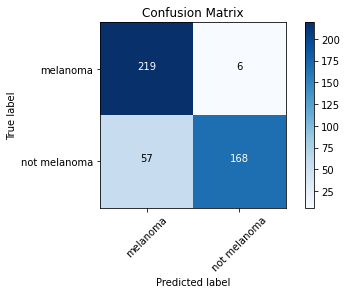

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction) 
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='binary')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='binary')
print('F-Measure: %.3f' % score)

In [ ]:
ensemble_model.save('/content/drive/MyDrive/Melanoma_Data/models/ensamble_model_2.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
